#Module

In [42]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [43]:
# Fungsi untuk menghasilkan K-mers dengan panjang 3 dari urutan DNA
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

In [44]:
df = pd.read_excel("../Dataset/Dataset_Preprocess.xlsx")
df = df[['urutan', 'kelas']]

In [45]:
df

,urutan,kelas
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0
...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1


In [46]:
df['kmers'] = df['urutan'].apply(lambda x: get_kmers(x, 3))
df

,urutan,kelas,kmers
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0,"[GTG, TGG, GGA, GAC, ACC, CCG, CGC, GCA, CAA, ..."
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0,"[TTT, TTC, TCA, CAT, ATT, TTT, TTT, TTA, TAC, ..."
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
...,...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAC, ACA, CAA, AAC, ACC, CCA, ..."
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."


Word 2 Vec

In [47]:
w2v_model = Word2Vec(df['kmers'], vector_size=100, window=5, min_count=1, workers=4)

In [48]:
# Fungsi untuk mendapatkan vektor Word2Vec untuk K-mers
def get_w2v_embedding(kmers, w2v_model):
    return np.array([w2v_model.wv[kmer] for kmer in kmers if kmer in w2v_model.wv])

In [49]:
# Terapkan Word2Vec untuk mendapatkan embedding dari 'kmers'
df['w2v_embedding'] = df['kmers'].apply(lambda x: get_w2v_embedding(x, w2v_model))

In [50]:
df

,urutan,kelas,kmers,w2v_embedding
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ...","[[-1.956361, -0.102420226, -0.12120944, -0.088..."
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ...","[[-1.956361, -0.102420226, -0.12120944, -0.088..."
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0,"[GTG, TGG, GGA, GAC, ACC, CCG, CGC, GCA, CAA, ...","[[0.891036, -0.02756279, -1.587175, -0.5407622..."
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0,"[TTT, TTC, TCA, CAT, ATT, TTT, TTT, TTA, TAC, ...","[[2.2381608, 0.36096856, -0.6260058, 1.9426937..."
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...","[[0.92936337, -1.1627932, -0.48093, 0.00825769..."
...,...,...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...","[[0.92936337, -1.1627932, -0.48093, 0.00825769..."
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...","[[0.92936337, -1.1627932, -0.48093, 0.00825769..."
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAC, ACA, CAA, AAC, ACC, CCA, ...","[[0.92936337, -1.1627932, -0.48093, 0.00825769..."
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...","[[0.92936337, -1.1627932, -0.48093, 0.00825769..."


In [51]:
max_len = 64

X - y

In [52]:
X = pad_sequences(df['w2v_embedding'].apply(lambda x: np.array(x)), maxlen=max_len, dtype='float32', padding='post', truncating='post')
y = df['kelas'].values


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1256, 64, 100)
Shape of y: (1256,)


In [53]:
# Membagi data menjadi training dan testing set dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes dari data yang sudah di-split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1004, 64, 100)
Shape of X_test: (252, 64, 100)
Shape of y_train: (1004,)
Shape of y_test: (252,)


In [54]:
from GCallbacks import PlotLosses, checkpoint_callback, TimeHistory, PlotTimes

# Inisialisasi callback
plot_losses_callback = PlotLosses()
time_callback = TimeHistory()
plot_times_callback = PlotTimes(time_callback)
call = [plot_losses_callback, time_callback, plot_times_callback, checkpoint_callback]

In [55]:
X_train.shape[1]

64

In [56]:
X_train.shape[2]

100

In [57]:
# Membuat model LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [58]:
# Melatih model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=call)

Epoch 1/70
32/32 [==============================] - 2s 37ms/step - loss: 0.3060 - accuracy: 0.8576 - val_loss: 0.2281 - val_accuracy: 0.8571
Epoch 2/70
32/32 [==============================] - 1s 25ms/step - loss: 0.1935 - accuracy: 0.9004 - val_loss: 0.1733 - val_accuracy: 0.9167
Epoch 3/70
32/32 [==============================] - 1s 25ms/step - loss: 0.1408 - accuracy: 0.9373 - val_loss: 0.1074 - val_accuracy: 0.9524
Epoch 4/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0838 - accuracy: 0.9661 - val_loss: 0.0855 - val_accuracy: 0.9524
Epoch 5/70
32/32 [==============================] - 1s 22ms/step - loss: 0.1326 - accuracy: 0.9512 - val_loss: 0.1299 - val_accuracy: 0.9563
Epoch 6/70
32/32 [==============================] - 1s 20ms/step - loss: 0.1056 - accuracy: 0.9582 - val_loss: 0.0988 - val_accuracy: 0.9643
Epoch 7/70
32/32 [==============================] - 2s 55ms/step - loss: 0.0862 - accuracy: 0.9691 - val_loss: 0.0719 - val_accuracy: 0.9643
Epoch 8/70
32

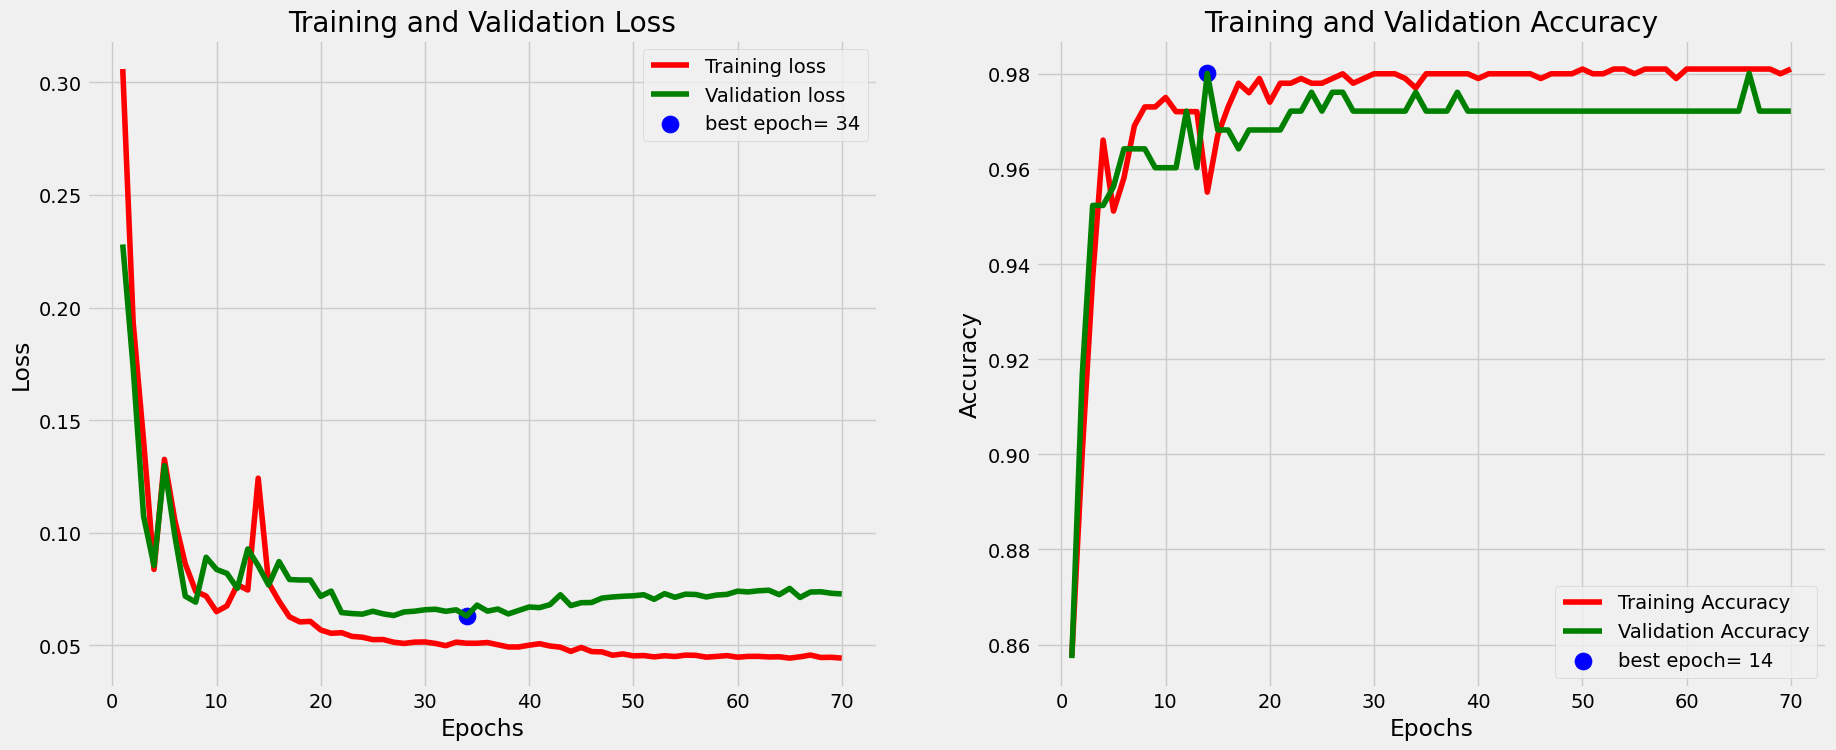

In [60]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [61]:
# Muat bobot dari file HDF5
model.load_weights('Checkpoints/model_epoch_14.h5')

In [62]:
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

8/8 [==============================] - 0s 7ms/step
Accuracy: 0.98
Precision: 0.97
Recall: 0.99
F1-Score: 0.98


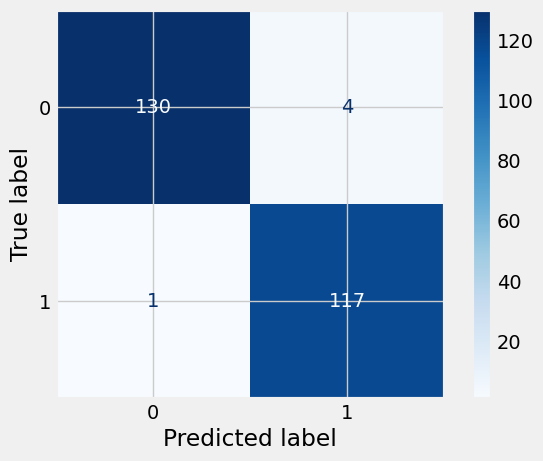

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()